# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# для анализа и работы с данными
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# алгоритмы машинного обучения
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

# метрики 
from sklearn.metrics import mean_squared_error

# счетчик времени
import time


In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
# Созадим функцию для анализа таблиц
def analysis(data):
    print(100*'-')
    print('Общая информамия:')
    print(data.info())
    
    print(100*'-')
    print('Первые 5 строк')
    display(data.head(5))
    
    print(100*'-')
    print('Количество пропусков')
    print(data.isnull().sum())
    
    print(100*'-')
    print('Количество дубликатов:')
    display(data.duplicated().sum())
    
    print(100*'-')
    print('Статистические данные')
    display(data.describe())
    
    print(100*'-')
    print('Общиегистограммы')
    data.hist(figsize = (10, 10))
    plt.show()

----------------------------------------------------------------------------------------------------
Общая информамия:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 1

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


----------------------------------------------------------------------------------------------------
Количество пропусков
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64
----------------------------------------------------------------------------------------------------
Количество дубликатов:


4

----------------------------------------------------------------------------------------------------
Статистические данные


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


----------------------------------------------------------------------------------------------------
Общиегистограммы


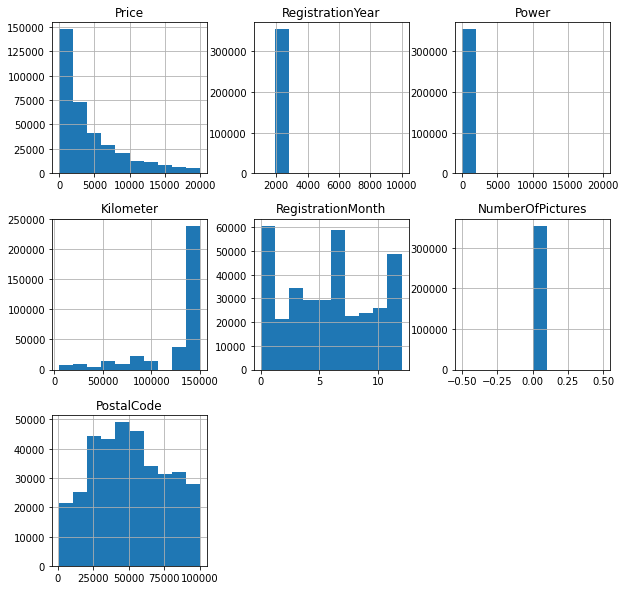

In [4]:
analysis(data)

In [5]:
# Приведем названию столбцов к нижнему гегистру
data.columns = data.columns.str.lower()
data.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

Разберем значение каждого столбца :
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [6]:
# Проверим зависимость между показателями
data.corr()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
registrationyear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
registrationmonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
numberofpictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postalcode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


В первую очередь избавимся от стобцов, которые не несут для нас информации, которая необходима для построения модели. Т.е. найдем те параметры, которые никак не оказывают влияния на целевой признак. Для нас это будут столбцы: datecrawled, datecreated, numberofpictures, lastseen.

In [7]:
# Удаление ненужных столбцов
data.drop(['datecrawled', 'datecreated', 'numberofpictures', 'lastseen'], axis=1, inplace=True)
# Проверка
data.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'registrationmonth', 'fueltype', 'brand', 'repaired',
       'postalcode'],
      dtype='object')

Также у нас имеется 4 явных дубликата, избавимся от них.

In [8]:
# Удаление дубликатов
data = data.drop_duplicates()
# Проверка
data.duplicated().sum()

0

Теперь пройдемся по каждому столбцу отдельно для выявления аномальных значений и заполнения пропусков там где это вохможно.

### Столбец price

AxesSubplot(0.125,0.125;0.775x0.755)
count    333036.000000
mean       4378.277586
std        4502.534823
min           0.000000
25%        1000.000000
50%        2699.000000
75%        6299.250000
max       20000.000000
Name: price, dtype: float64
Количество пропусков: 0


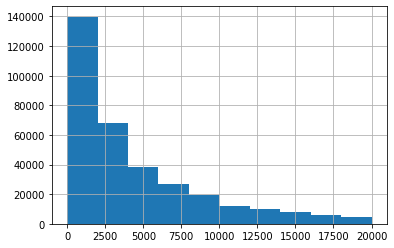

In [9]:
print(data['price'].hist())
print(data['price'].describe())
print('Количество пропусков:', data['price'].isnull().sum())


Данный признак у нас является целевым, поэтому при его анализе мы видим, что у нас имеется нулевые значения.Эти данные буду сильно влиять на качество моедли, поэтому слишком дешевые автомобили удалим для лучшего обучения модели. Примем нижнюю границу в 100 евро.

In [10]:
data = data.drop(data.query('price < 100').index)
# Проверка
data['price'].describe()

count    320571.000000
mean       4548.300963
std        4504.301955
min         100.000000
25%        1200.000000
50%        2850.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

### Столбец registrationyear

AxesSubplot(0.125,0.125;0.775x0.755)
count    320571.000000
mean       2003.932636
std          71.090126
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64
Количество пропусков: 0


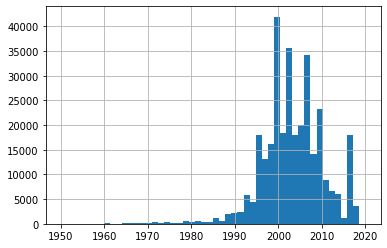

In [11]:
print(data['registrationyear'].hist(range=[1950,2020], bins=50))
print(data['registrationyear'].describe())
print('Количество пропусков:', data['registrationyear'].isnull().sum())

Как видно пропуска отсутствуют, но при это имеются аномальные значения. Примем границы для объявлений начиная с 1970 года до 2019.

In [12]:
data = data[(data['registrationyear'] >= 1970) & (data['registrationyear'] <= 2019)]
data['registrationyear'].describe()

count    319409.000000
mean       2003.311832
std           6.912197
min        1970.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registrationyear, dtype: float64

### Столбец gearbox

AxesSubplot(0.125,0.125;0.775x0.755)
count     304040
unique         2
top       manual
freq      243904
Name: gearbox, dtype: object
Количество пропусков: 15369


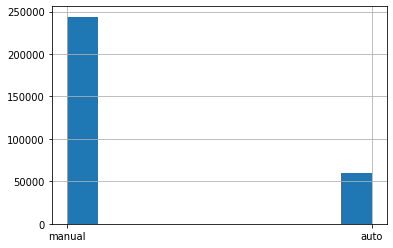

In [13]:
print(data['gearbox'].hist())
print(data['gearbox'].describe())
print('Количество пропусков:', data['gearbox'].isnull().sum())


В данном столбце два уникальных значения, имеется порядка 15000 пропусков. Удалять данные пропуски нет смысла, количетсво машин на механичской коробке передач намного больше чем на автомате, по этой причине можно предположить, что если значение не указано, то там должна стоять механическая коробка передач. Заполним пустые значения нулевым значением, а также приравняем механику к 0, а автоматическую коробку к 1.

<AxesSubplot:>

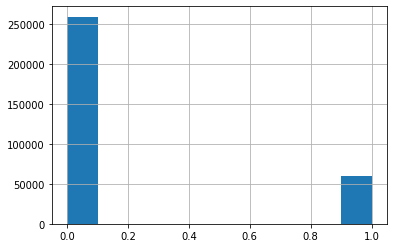

In [14]:
# заменим пропуски на 0
data['gearbox'].fillna(0, inplace=True)
data.loc[(data.gearbox == 'manual'), 'gearbox'] = 0   
data.loc[(data.gearbox == 'auto'), 'gearbox'] = 1
data['gearbox'].hist()

### Столбец power

AxesSubplot(0.125,0.125;0.775x0.755)
count    319409.000000
mean        111.159012
std         190.830980
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64
Количество пропусков: 0


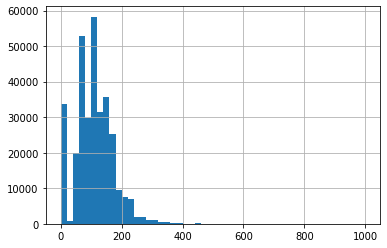

In [15]:
print(data['power'].hist(range=[0, 1000], bins=50))
print(data['power'].describe())
print('Количество пропусков:', data['power'].isnull().sum())

Пропуска отсутствуют, но имеются аномальные значения. Примем границы для мощности авто в диапазоне от 10 до 1000 л.с.

In [16]:
data = data[(data['power'] >= 10) & (data['power'] <= 1000)]
data['power'].describe()

count    285652.000000
mean        120.302907
std          54.446619
min          10.000000
25%          75.000000
50%         110.000000
75%         150.000000
max        1000.000000
Name: power, dtype: float64

### Столбцы kilometer, registrationmonth, brand

AxesSubplot(0.125,0.125;0.775x0.755)
count    285652.000000
mean     128729.993139
std       36469.920364
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64
Количество пропусков: 0


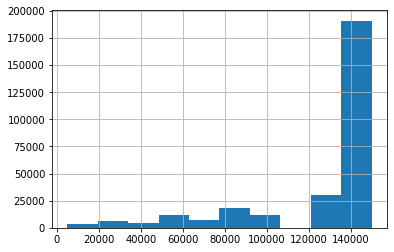

In [17]:
print(data['kilometer'].hist())
print(data['kilometer'].describe())
print('Количество пропусков:', data['kilometer'].isnull().sum())

Пробег автомобиля никаких пропусков и аномалий не представляет, поэтому оставим данный столбец без изменений.

AxesSubplot(0.125,0.125;0.775x0.755)
count    285652.000000
mean          5.952971
std           3.600745
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registrationmonth, dtype: float64
Количество пропусков: 0


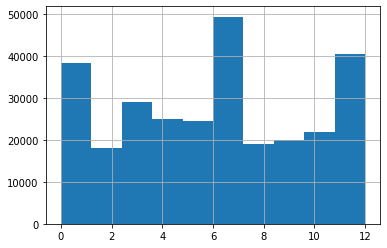

In [18]:
print(data['registrationmonth'].hist())
print(data['registrationmonth'].describe())
print('Количество пропусков:', data['registrationmonth'].isnull().sum())

В столбце registrationmonth также все данные отвечают требованиям оставляем как есть.

In [19]:
print(data['brand'].describe())
print('Количество пропусков:', data['brand'].isnull().sum())

count         285652
unique            40
top       volkswagen
freq           62359
Name: brand, dtype: object
Количество пропусков: 0


В столбце brand пропуски отсутсвуют, уникальных значений 40 оставляем.

### Столбец repaired

AxesSubplot(0.125,0.125;0.775x0.755)
count     241107
unique         2
top           no
freq      213047
Name: repaired, dtype: object
Количество пропусков: 44545


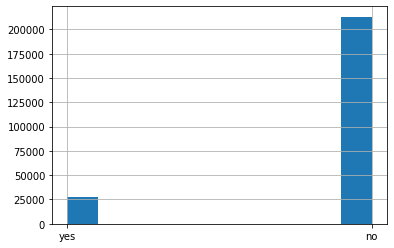

In [20]:
print(data['repaired'].hist())
print(data['repaired'].describe())
print('Количество пропусков:', data['repaired'].isnull().sum())

В данном столбце представлена информация по ремонту автомобиля, здесь можно провести анологию с коробкой автомобиля. Имеется большое количество пропусков, логично будет предположить если даныые пропущены, то машина не была в ремонте. Заменим пустые значения нулевым, и приравняем значения к единице и нулю.

<AxesSubplot:>

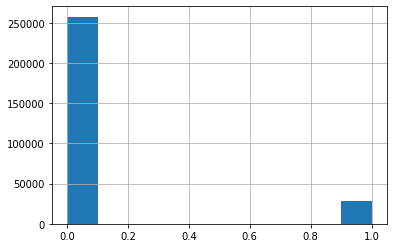

In [21]:
# заменим пропуски 0
data['repaired'].fillna(0, inplace=True)
data.loc[(data.repaired == 'no'), 'repaired'] = 0   
data.loc[(data.repaired == 'yes'), 'repaired'] = 1
data['repaired'].hist()

### Столбец fueltype

AxesSubplot(0.125,0.125;0.775x0.755)
count     266713
unique         7
top       petrol
freq      178402
Name: fueltype, dtype: object
Количество пропусков: 18939
['gasoline' 'petrol' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


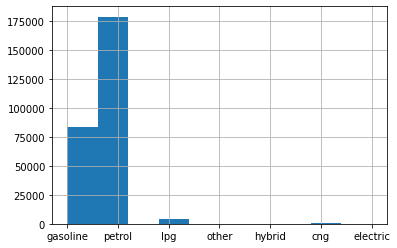

In [22]:
print(data['fueltype'].hist())
print(data['fueltype'].describe())
print('Количество пропусков:', data['fueltype'].isnull().sum())
print(data['fueltype'].unique())

По умолчанию где имеются пропуски логично будет заменить значения на бензиновый двигатель, т.к. он наиболее популярный. Для задач машинного обучения переведем данный категориальный признак в числовой для более лекого обучения модели.
'petrol' =  1
'gasoline' = 2
'lpg' = 3
'hybrid' = 4
'cng' = 5
'electric' = 6
'other' = 0

<AxesSubplot:>

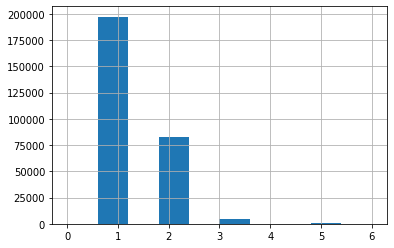

In [23]:
# Замена значений
data['fueltype'].fillna(1, inplace=True)
# Новые значения
data['fueltype'].replace({'petrol': 1,
                        'gasoline': 2,
                        'lpg': 3,
                        'hybrid': 4,
                        'cng': 5,
                        'electric': 6,
                        'other': 0}, inplace=True)
data['fueltype'].hist()

### Столбец vehicletype	и model

In [24]:
print('Количество пропусков')
print(data.isnull().sum())

Количество пропусков
price                    0
vehicletype          20276
registrationyear         0
gearbox                  0
power                    0
model                11560
kilometer                0
registrationmonth        0
fueltype                 0
brand                    0
repaired                 0
postalcode               0
dtype: int64


Как видим у нас остались пропуски в двух категориальных признаках, данные значения влияют на целевой признак, а заменить их не представляется возможным, по этому будет лучше удалить данные признаки.

----------------------------------------------------------------------------------------------------
Общая информамия:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 256528 entries, 2 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              256528 non-null  int64 
 1   vehicletype        256528 non-null  object
 2   registrationyear   256528 non-null  int64 
 3   gearbox            256528 non-null  object
 4   power              256528 non-null  int64 
 5   model              256528 non-null  object
 6   kilometer          256528 non-null  int64 
 7   registrationmonth  256528 non-null  int64 
 8   fueltype           256528 non-null  int64 
 9   brand              256528 non-null  object
 10  repaired           256528 non-null  object
 11  postalcode         256528 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 25.4+ MB
None
------------------------------------------

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,postalcode
2,9800,suv,2004,1,163,grand,125000,8,2,jeep,0,90480
3,1500,small,2001,0,75,golf,150000,6,1,volkswagen,0,91074
4,3600,small,2008,0,69,fabia,90000,7,2,skoda,0,60437
5,650,sedan,1995,0,102,3er,150000,10,1,bmw,1,33775
6,2200,convertible,2004,0,109,2_reihe,150000,8,1,peugeot,0,67112


----------------------------------------------------------------------------------------------------
Количество пропусков
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
repaired             0
postalcode           0
dtype: int64
----------------------------------------------------------------------------------------------------
Количество дубликатов:


2885

----------------------------------------------------------------------------------------------------
Статистические данные


,price,registrationyear,power,kilometer,registrationmonth,fueltype,postalcode
count,256528.000000,256528.000000,256528.000000,256528.000000,256528.000000,256528.000000,256528.000000
mean,4952.449850,2002.733300,121.242246,128303.070230,6.070137,1.346917,51626.379923
std,4625.038053,5.914203,54.042869,36512.227365,3.539466,0.535328,25756.363761
min,100.000000,1970.000000,10.000000,5000.000000,0.000000,0.000000,1067.000000
25%,1400.000000,1999.000000,80.000000,125000.000000,3.000000,1.000000,31174.000000
50%,3300.000000,2003.000000,114.000000,150000.000000,6.000000,1.000000,50769.000000
75%,7000.000000,2007.000000,150.000000,150000.000000,9.000000,2.000000,72461.000000
max,20000.000000,2018.000000,1000.000000,150000.000000,12.000000,6.000000,99998.000000


----------------------------------------------------------------------------------------------------
Общиегистограммы


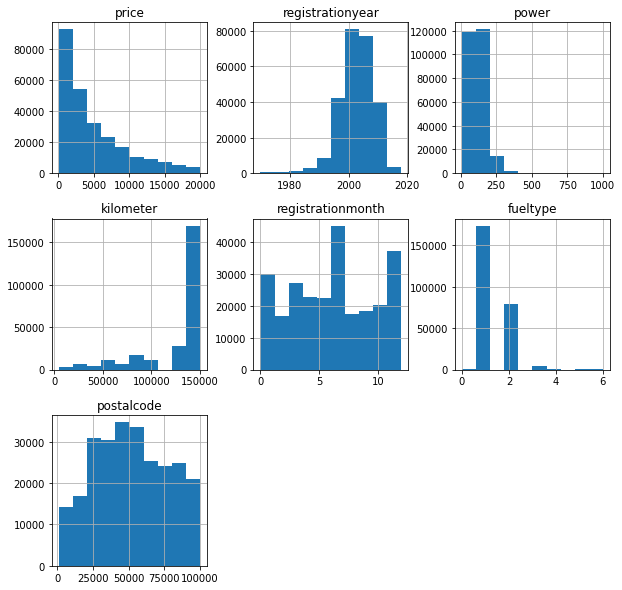

In [25]:
data.dropna(inplace=True)
# Итоговая проверка всего датафрейма
analysis(data)

**Вывод:** Были изучены и обработаны исходные данные проекта, были установлены аномальные значения и пропуски, а также была произведена чистка и заполенения данных  в тех местах, где это представлялось возможным.
После предобработки данных количетсво наблюдений сократилось с 354369 до 256528 датасет сократился почти на 22% это вынужденная мера для задач машинного обучения, но даже после такого сокращения количество оставшихся данных хватит для задач построения актулаьной модели. 

In [26]:
# КОД РЕВЬЮЕРА
data.duplicated().sum()

2885

In [27]:
# Удаление дубликатов
data = data.drop_duplicates()
# Проверка
data.duplicated().sum()

0

## Обучение моделей

Для начала необходимо разделить признаки на категориальные и числовые признаки, для категориальных применим кодирование методом OrdinalEncoder, а для количественных проведем масштабирование. Так же разделим наш исходный датасает на 3 выборки: обучающую, валидационную и тестовую.

In [28]:
# разбивка на  категориальные и числовые признаки
cat_column = ['vehicletype', 'gearbox', 'model', 'fueltype',
                        'brand', 'repaired', 'postalcode']
num_column = ['registrationyear', 'power', 'kilometer', 'registrationmonth']

In [29]:
# разделим целевой и обучающие признаки
features = data.drop('price',axis=1)
target = data['price']

In [30]:
# разделяем данные на обучающую и валидационную выборки 
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.40, random_state = 12345)

# разделяем остаток валидационную и тестовую выборку
features_valid, features_test, target_valid, target_test = train_test_split(
    features, target, test_size=0.50, random_state = 12345)

print("Размер обучающей выборки:", features_train.shape)
print("Размер валидационной выборки:", features_valid.shape)
print("Размер тестовой выборки:", features_test.shape)

Размер обучающей выборки: (152185, 11)
Размер валидационной выборки: (126821, 11)
Размер тестовой выборки: (126822, 11)


In [31]:
# Масштабирование количественных признаков
scaler = StandardScaler()
scaler.fit(features_train[num_column])
features_train[num_column] = scaler.transform(features_train[num_column])
features_valid[num_column] = scaler.transform(features_valid[num_column])
features_test[num_column] = scaler.transform(features_test[num_column])

In [32]:
# Обработка категориальных признаков
encoder = OrdinalEncoder(handle_unknown='ignore')
encoder.fit(features_train[cat_column])

features_train[cat_column] = encoder.transform(features_train[cat_column])
features_valid[cat_column] = encoder.transform(features_valid[cat_column])
features_test[cat_column] = encoder.transform(features_test[cat_column])

Создадим функции для подсчета времени обучения и предсказания модели. На вход функции дается модель обучения,а также тренировычные данные по целевому и обучающим признакам, на выходе первой функции подсчета времени обучения модели будет выходить время обучения, а также непосредтвенно обученая модель. Во второй функции на вход идет модель из первой функции и признаки валидационной выборке, на выходе вторая функция выводит время предсказания, а также предсказанное значение.

In [33]:
# Функция для подсчета времени обучения
def time_fit(model, features_train, target_train):
    start = time.time()
    model.fit(features_train, target_train)
    end = time.time()
    fit_time = end - start
    return fit_time, model
# Функция для подсчета времени предсказания
def time_predict(model, features_vaild):
    start = time.time()
    predict = model.predict(features_vaild)
    end = time.time()
    predict_time = end - start
    return predict_time, predict

### Модель RandomForestRegressor

In [ ]:
RF_time_fit, model_RF = time_fit(RandomForestRegressor(n_estimators=100, random_state=12345), features_train, target_train)
RF_time_predict, predict_RF = time_predict(model_RF, features_valid)
RMSE_RF = np.sqrt(mean_squared_error(target_valid, predict_RF))
print('Время обучения модели RandomForestRegressor', RF_time_fit)
print('Время предсказания модели RandomForestRegressor', RF_time_predict)
print('RMSE модели RandomForestRegressor', RMSE_RF)

### Модель CatBoostRegressor

Для модели CatBoostRegressor проведем подбор гиперпараметров с помощью функции GridSearchCV, будем изучать два параметра это глубину дерева depth и скорость обучения модели learning_rate. После этого лучшие гиперпараметры подставим в нашу функцию и найдем необходимые показатели.

In [43]:
model = CatBoostRegressor()
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              }

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(features_train, target_train)

0:	learn: 4578.5197016	total: 12ms	remaining: 12s
1:	learn: 4547.8342955	total: 21.9ms	remaining: 10.9s
2:	learn: 4517.2017395	total: 31.5ms	remaining: 10.5s
3:	learn: 4486.2834700	total: 41.3ms	remaining: 10.3s
4:	learn: 4455.3113578	total: 51ms	remaining: 10.2s
5:	learn: 4425.0925958	total: 60.8ms	remaining: 10.1s
6:	learn: 4394.9066681	total: 71.3ms	remaining: 10.1s
7:	learn: 4365.2758737	total: 80.9ms	remaining: 10s
8:	learn: 4336.3648057	total: 91.1ms	remaining: 10s
9:	learn: 4307.6929670	total: 101ms	remaining: 10s
10:	learn: 4279.1569760	total: 112ms	remaining: 10s
11:	learn: 4251.3827047	total: 122ms	remaining: 10s
12:	learn: 4224.1348599	total: 133ms	remaining: 10.1s
13:	learn: 4196.5873241	total: 143ms	remaining: 10.1s
14:	learn: 4169.7849155	total: 155ms	remaining: 10.1s
15:	learn: 4143.3799755	total: 165ms	remaining: 10.2s
16:	learn: 4117.2061596	total: 176ms	remaining: 10.2s
17:	learn: 4091.0039819	total: 187ms	remaining: 10.2s
18:	learn: 4065.4273711	total: 198ms	remainin

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fa52b285310>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [47]:
print('Параметры лучшей модели:', grid.best_params_)

Параметры лучшей модели: {'depth': 10, 'learning_rate': 0.1}


In [45]:
CB_time_fit, model_CB = time_fit(CatBoostRegressor(
    loss_function='RMSE', depth = 10, learning_rate=0.1, verbose=100, n_estimators=1000, random_state=12345), features_train, target_train)
CB_time_predict, predict_CB = time_predict(model_CB, features_valid)
RMSE_CB = np.sqrt(mean_squared_error(target_valid, predict_CB))
print('Время обучения модели CatBoostRegressor', CB_time_fit)
print('Время предсказания модели CatBoostRegressor', CB_time_predict)
print('RMSE модели CatBoostRegressor', RMSE_CB)

0:	learn: 4286.7045614	total: 44.3ms	remaining: 44.2s
100:	learn: 1590.6120844	total: 4.15s	remaining: 36.9s
200:	learn: 1489.6790924	total: 8.3s	remaining: 33s
300:	learn: 1424.7936899	total: 12.4s	remaining: 28.8s
400:	learn: 1377.4638950	total: 16.5s	remaining: 24.6s
500:	learn: 1338.7398237	total: 20.6s	remaining: 20.5s
600:	learn: 1305.2253566	total: 24.7s	remaining: 16.4s
700:	learn: 1275.3438350	total: 28.9s	remaining: 12.3s
800:	learn: 1249.5671760	total: 33s	remaining: 8.2s
900:	learn: 1226.2699485	total: 37.1s	remaining: 4.08s
999:	learn: 1204.1085593	total: 41.4s	remaining: 0us
Время обучения модели CatBoostRegressor 42.6913948059082
Время предсказания модели CatBoostRegressor 0.45757484436035156
RMSE модели CatBoostRegressor 1207.43168247472


### Модель LGBMRegressor

In [37]:
LGB_time_fit, model_LGB = time_fit(LGBMRegressor(
    n_estimators=1000, random_state=12345, learning_rate=0.4, objective='rmse'), features_train, target_train)
LGB_time_predict, predict_LGB = time_predict(model_LGB, features_valid)
RMSE_LGB = np.sqrt(mean_squared_error(target_valid, predict_LGB))
print('Время обучения модели LGBMRegressor', LGB_time_fit)
print('Время предсказания модели LGBMRegressor', LGB_time_predict)
print('RMSE модели LGBMRegressor', RMSE_LGB)

Время обучения модели LGBMRegressor 30.511650800704956
Время предсказания модели LGBMRegressor 7.892290353775024
RMSE модели LGBMRegressor 1017.6376307443574


## Анализ моделей

Соберем все параметры в одном месте.

In [48]:
print('Время обучения модели RandomForestRegressor', RF_time_fit)
print('Время предсказания модели RandomForestRegressor', RF_time_predict)
print('RMSE модели RandomForestRegressor', RMSE_RF)
print(100*'-')
print('Время обучения модели CatBoostRegressor', CB_time_fit)
print('Время предсказания модели CatBoostRegressor', CB_time_predict)
print('RMSE модели CatBoostRegressor', RMSE_CB)
print(100*'-')
print('Время обучения модели LGBMRegressor', LGB_time_fit)
print('Время предсказания модели LGBMRegressor', LGB_time_predict)
print('RMSE модели LGBMRegressor', RMSE_LGB)

Время обучения модели RandomForestRegressor 60.847907066345215
Время предсказания модели RandomForestRegressor 5.129724979400635
RMSE модели RandomForestRegressor 599.416678546265
----------------------------------------------------------------------------------------------------
Время обучения модели CatBoostRegressor 42.6913948059082
Время предсказания модели CatBoostRegressor 0.45757484436035156
RMSE модели CatBoostRegressor 1207.43168247472
----------------------------------------------------------------------------------------------------
Время обучения модели LGBMRegressor 30.511650800704956
Время предсказания модели LGBMRegressor 7.892290353775024
RMSE модели LGBMRegressor 1017.6376307443574


**Вывод:** Модели CatBoostRegressor и LGBMRegressor показали неплохой показатель ошибки RMSE, но к сожалению время обучения и предсказания оставляет желать лучшего. Среди всех моделей наилуший показатель RMSE у RandomForestRegressor составляет 600, данный показатель соответствует нашему заданию, также время обучения и предсказания намного быстре по сравнению с градиентным бустингом. Поэтому для проверки на тестовой выбоке возьмем модель случайного леса.

### Проверка лучшей модели на тестовой выборке

Наилучший показатель у модели случайного леса, проверим данную модель на тестовой выборке.

In [49]:
predictions_RF = model_RF.predict(features_test)
RMSE_RF = np.sqrt(mean_squared_error(target_test, predictions_RF))
print('RMSE модели RandomForestRegressor', RMSE_RF)

RMSE модели RandomForestRegressor 1427.6220076561256


**Вывод:** После проведения проверки на тестовой выборке метрика RMSE увеличилась почти вдвое, но при этом остается в диапазоне нашего задания. Время обучения и предсказания модели случайного леса находстя на хорошем уровне, поэтому можно считать, что предложенная модель может быть использована заказчиком для выполения предсказаний.